In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, MultiTaskLassoCV, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import Graphviz

In [2]:
train = pd.read_csv('train.csv')
#train = train[train['y'] < 220]
label = train['y'].values.reshape(-1,1)
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv('test.csv')
label_test = test['ID']
test = pd.get_dummies(test)
#train = train[train['y'] < 220]

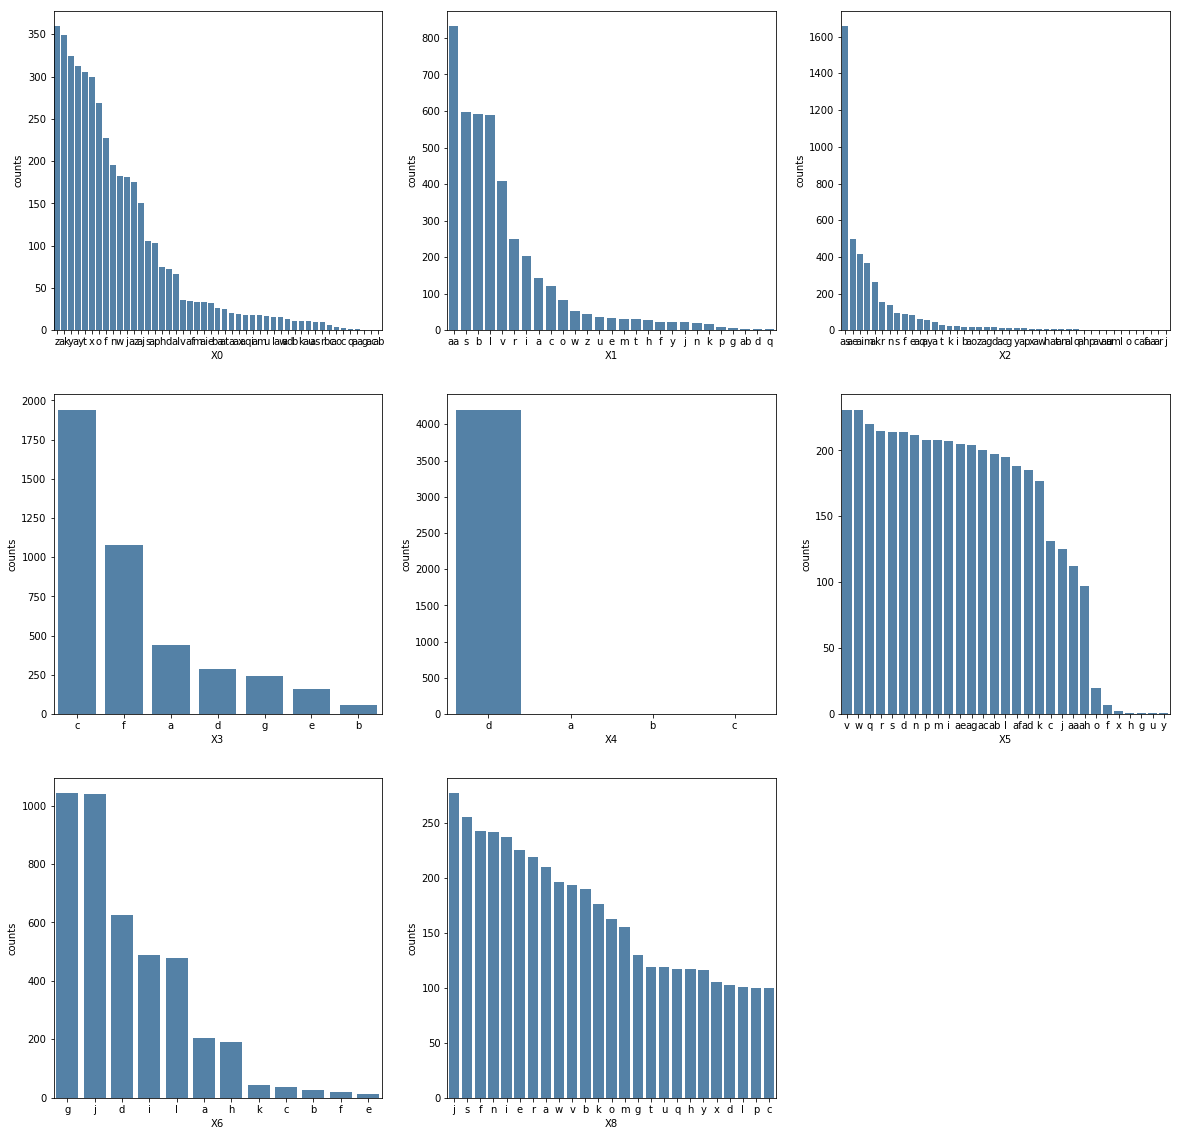

'X4 does not carry any information'

In [4]:
#Counts of Categorical Data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
categories =train.select_dtypes(exclude=["number"]).columns
for  i,category in enumerate(categories,1):
    plt.subplot(3, 3, i)
    sns.barplot(x=category , y='counts',
                       data=train.groupby([category]).size().reset_index(name='counts').sort_values('counts',
                                                                                            ascending = False), color = 'steelblue')
plt.show()
'''X4 does not carry any information'''

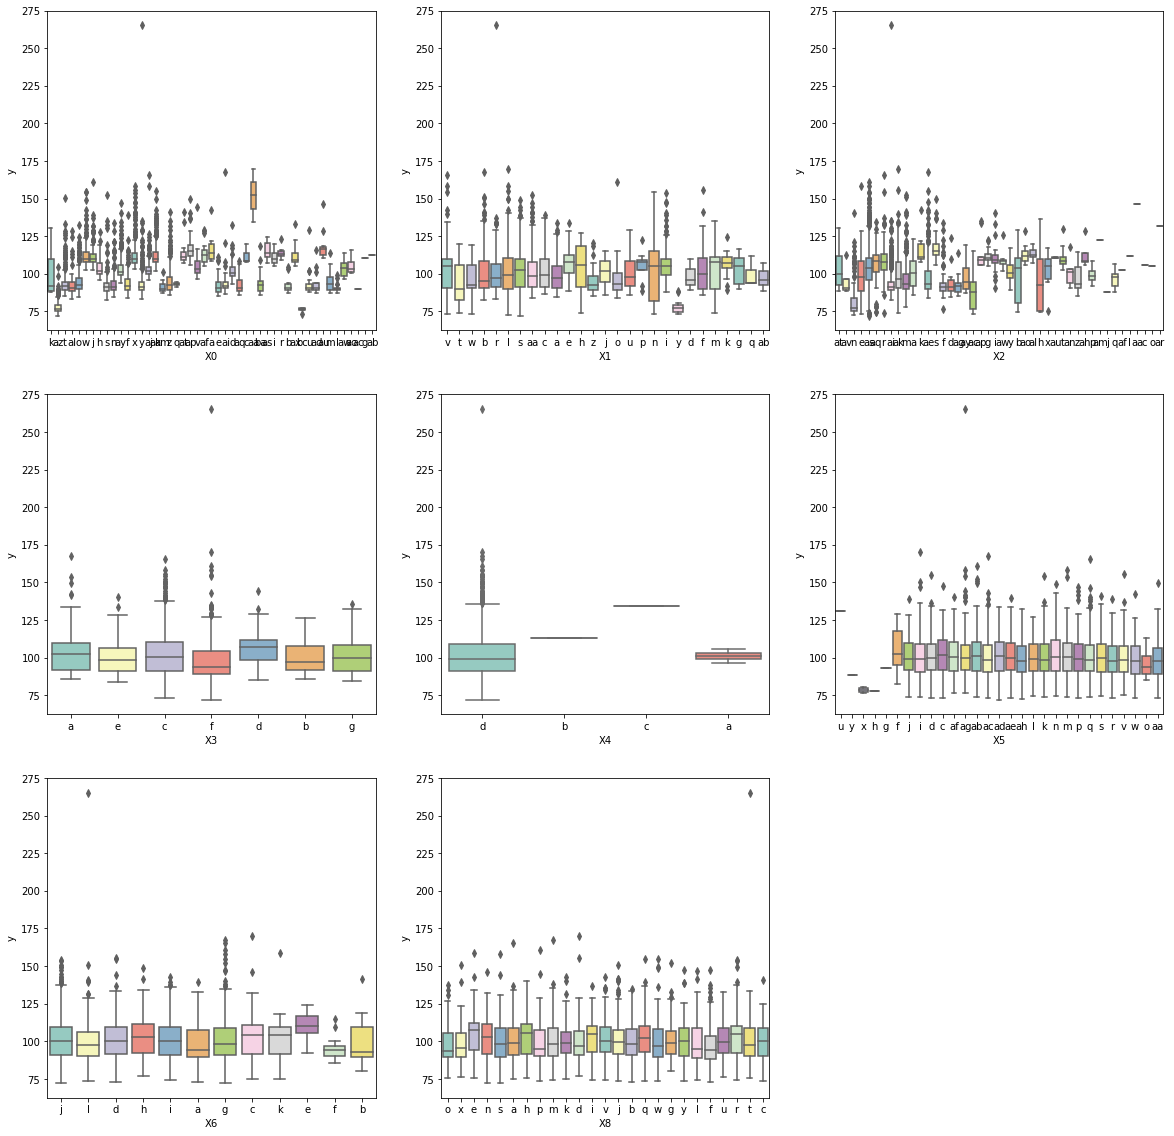

'We will focus on X0,X1,X2,X5'

In [5]:
#Look at Distibution of y among categorical variables
for  i,category in enumerate(categories,1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=category , y='y',
                       data=train , palette = 'Set3' )
plt.show()
'''We will focus on X0,X1,X2,X5'''

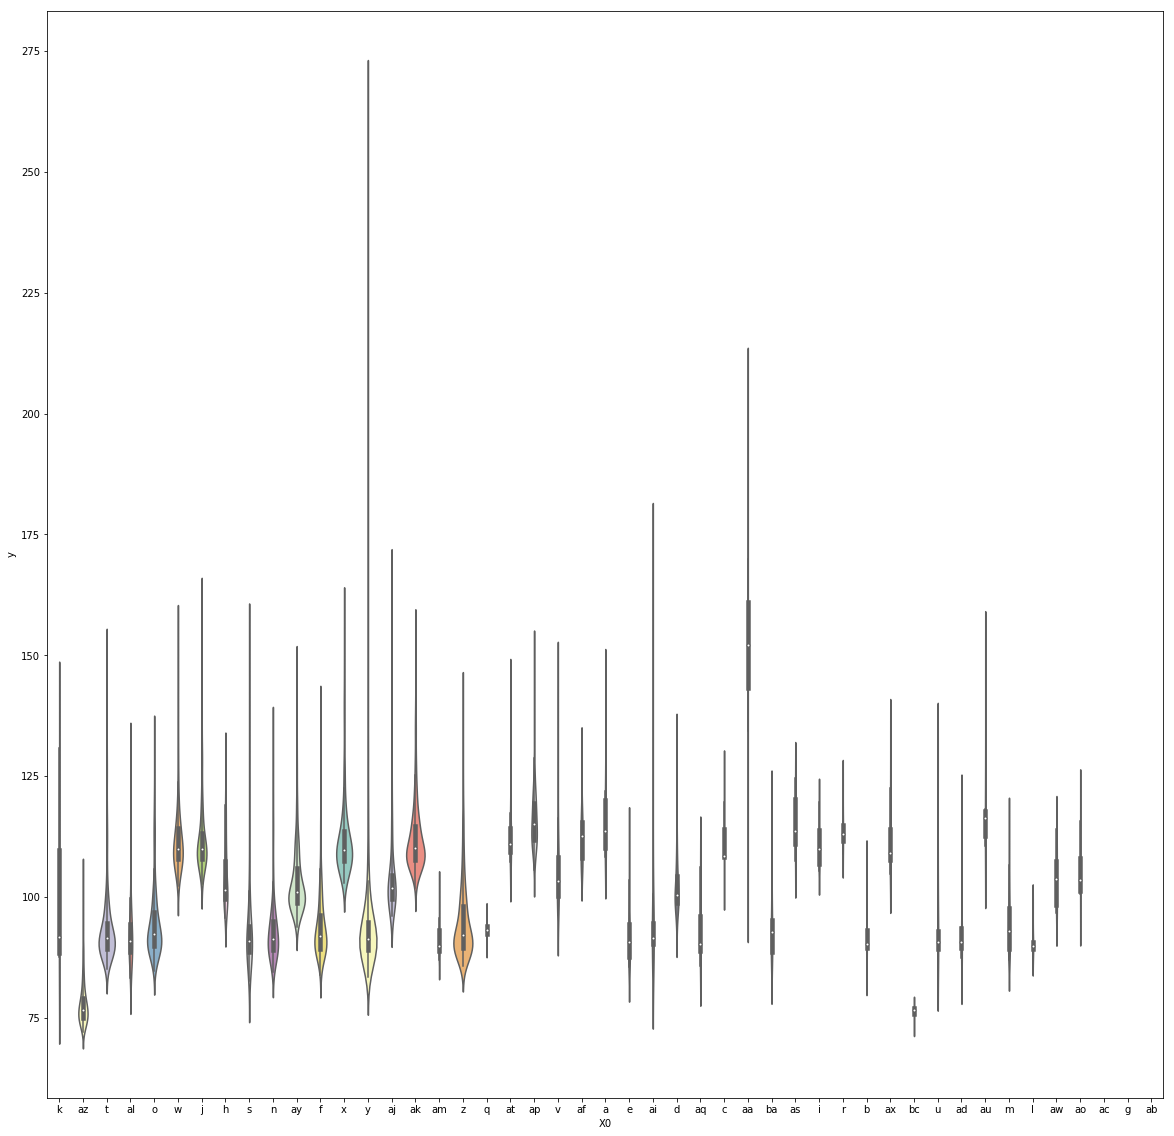

In [6]:
sns.violinplot(x='X0' , y='y',
                       data=train,palette = 'Set3', scale = 'count' )
plt.show()

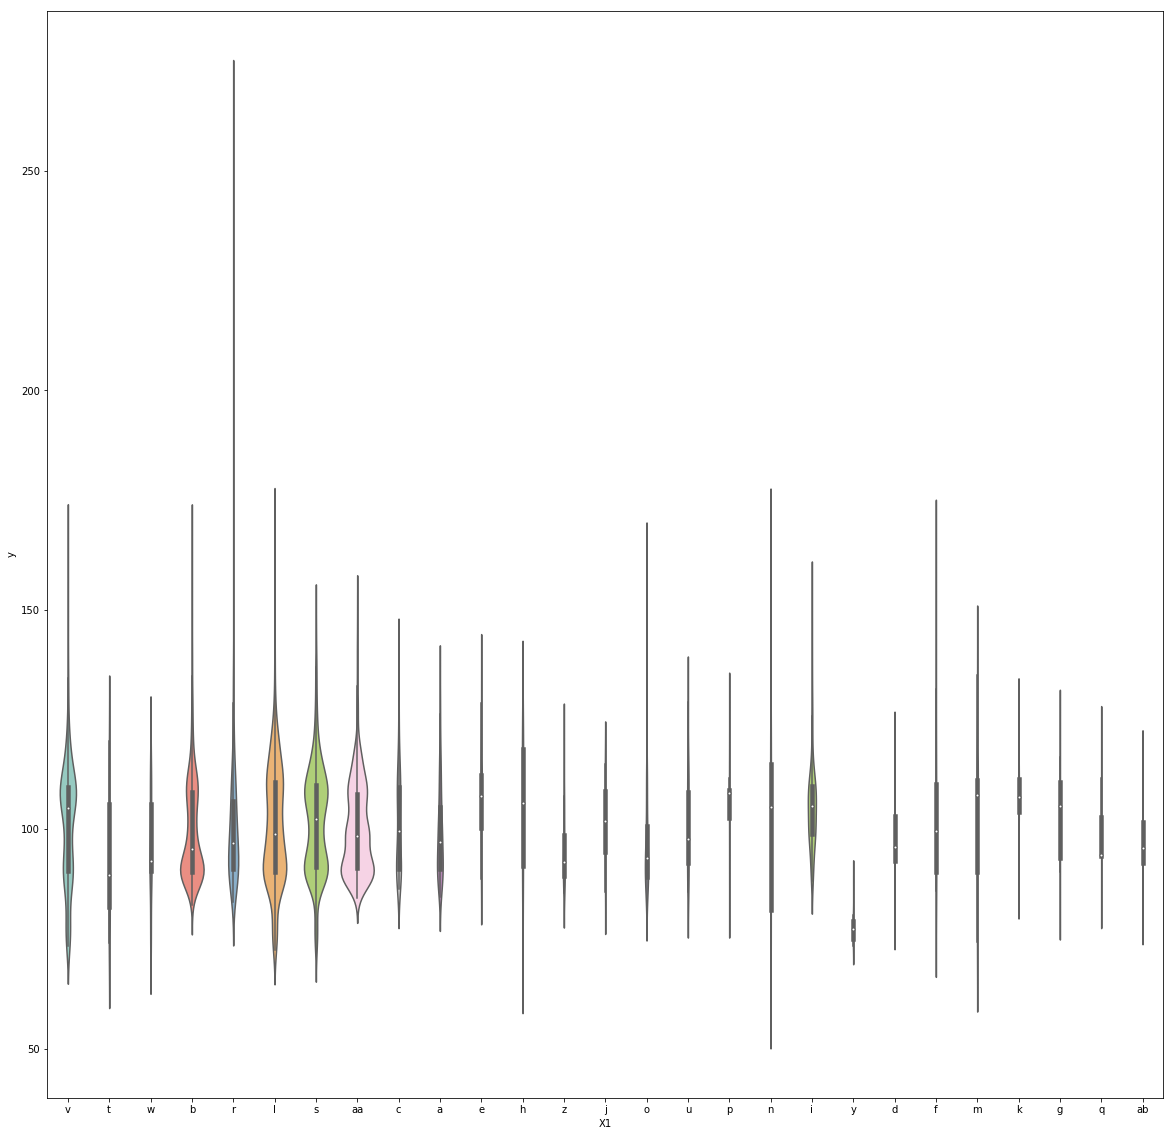

In [7]:
sns.violinplot(x='X1' , y='y',
                       data=train, palette = 'Set3', scale = 'count' )
plt.show()

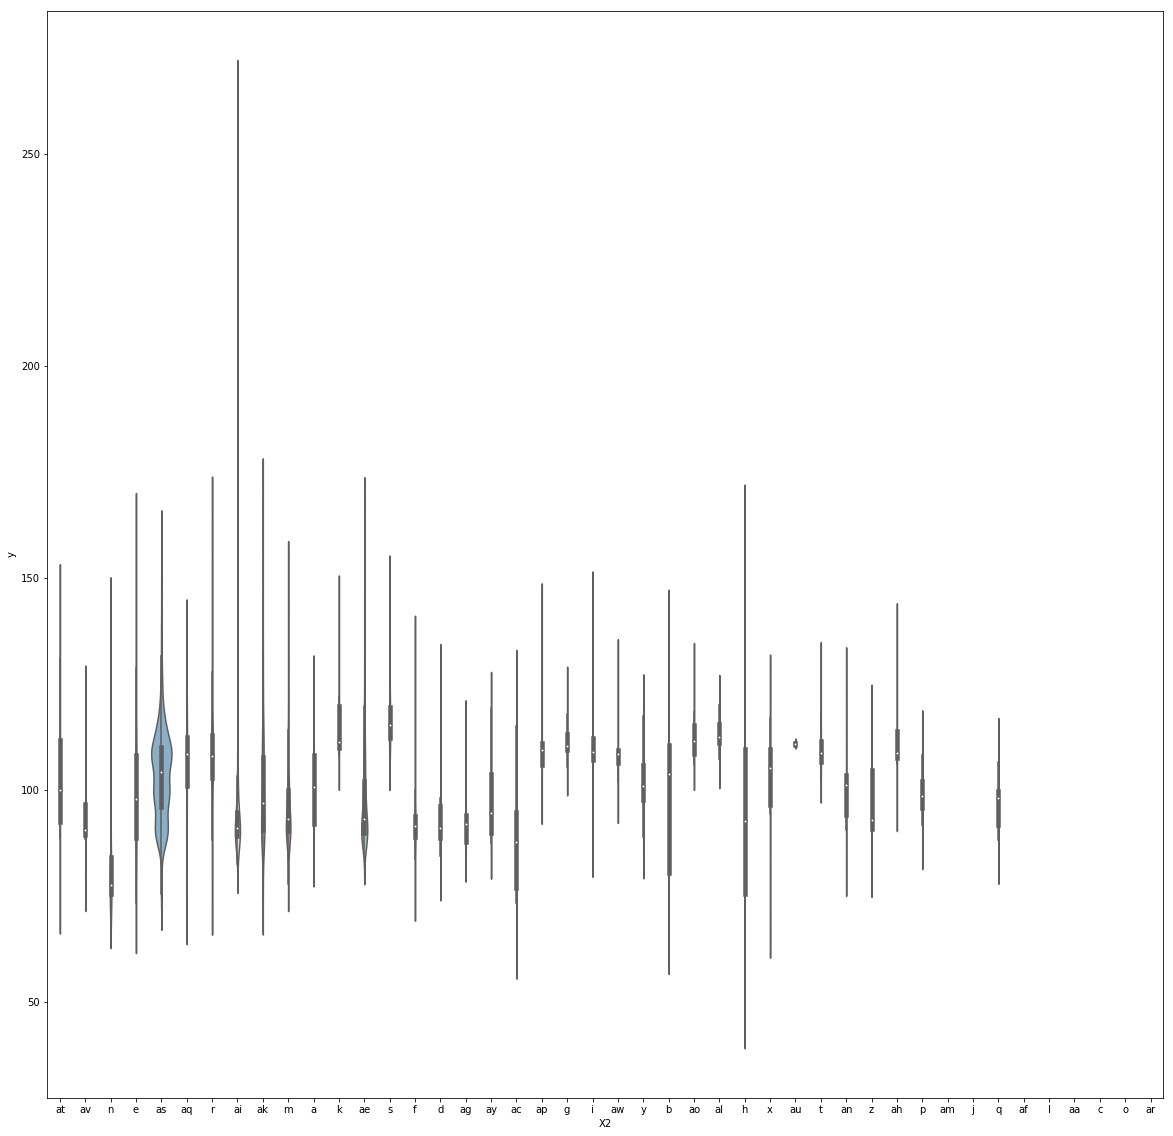

In [8]:
sns.violinplot(x='X2' , y='y',
                       data=train, palette = 'Set3', scale = 'count' )
plt.show()

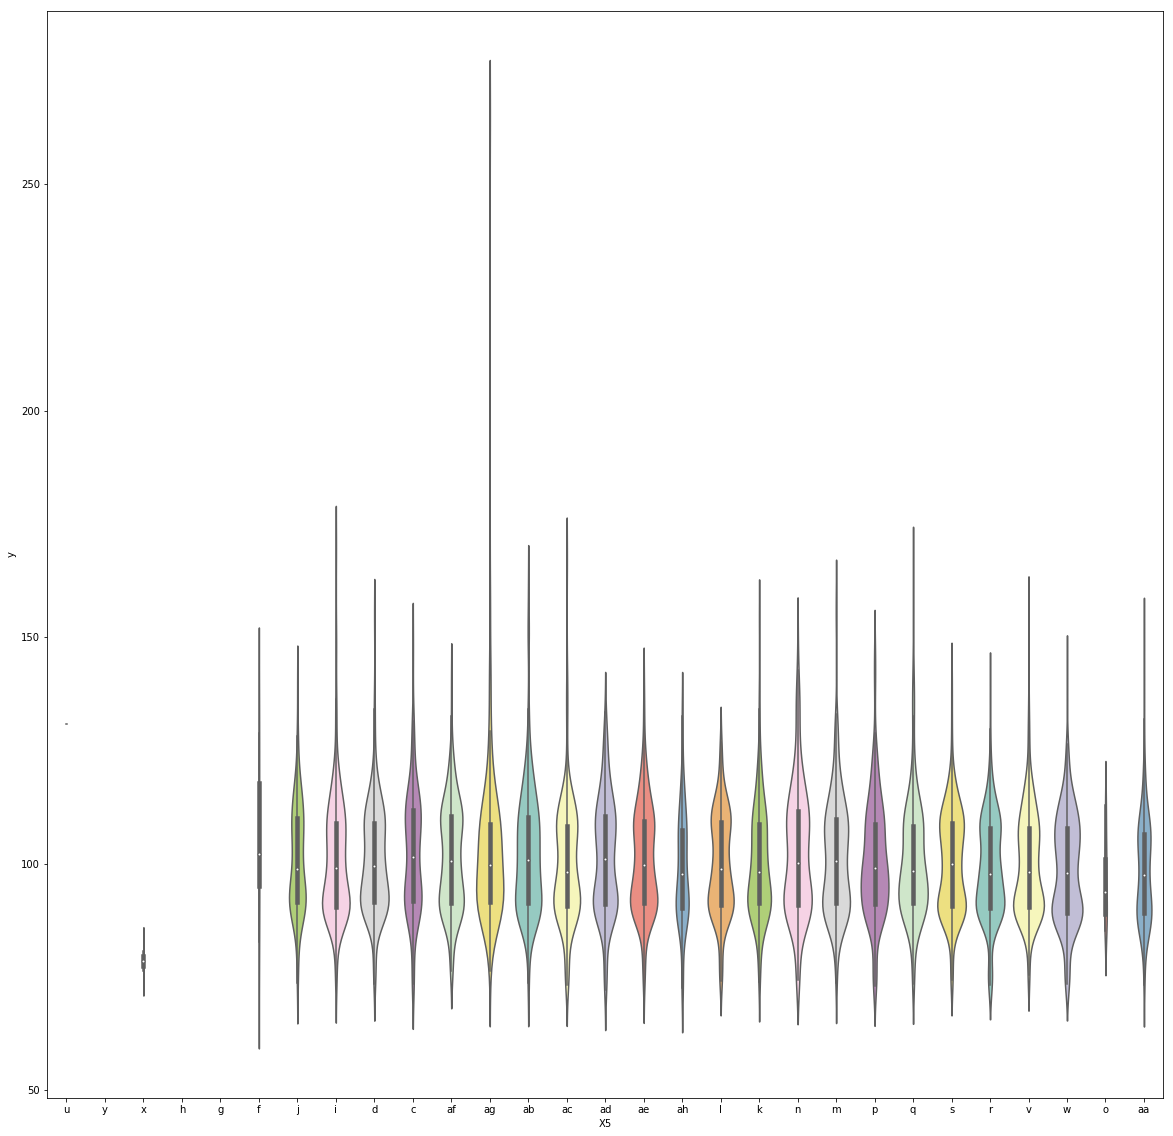

In [9]:
sns.violinplot(x='X5' , y='y',
                       data=train, palette = 'Set3', scale = 'count' )
plt.show()

In [10]:
#Removal of non informative columns
counts = train.loc[:,'X11':].apply(pd.value_counts)
inner_corr = train[counts.dropna(axis='columns').columns]

In [11]:
#Correlation between independent variables
corr = pd.concat((inner_corr,pd.get_dummies(train[categories], drop_first = True)),axis = 1).corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.70).any()
m2 = (corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.70).any()
#corr.sort_values('X21', ascending = False)
#corr.loc[m,m].loc[:,'X119'].sort_values()

In [12]:
#Let's try lasso feature selection
reg = MultiTaskLassoCV()
reg.fit(label, inner_corr)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(label,inner_corr))
coef = pd.DataFrame(reg.coef_, index = inner_corr.columns)
coef.columns = ['Scr']
lasso_candidates = coef[(coef.Scr < np.percentile(coef,10)) | (coef.Scr > np.percentile(coef,90))].sort_values('Scr' , ascending = False)
lasso_candidates.head(20)

Best alpha using built-in LassoCV: 0.483922
Best score using built-in LassoCV: 0.029699


,Scr
X314,0.022577
X261,0.021855
X119,0.009946
X118,0.009946
X275,0.009219
X311,0.007755
X51,0.007752
X191,0.007317
X14,0.007207
X251,0.007163


In [13]:
pd.concat((train[['y']], inner_corr),axis = 1).corr().iloc[:,[0]].sort_values('y',ascending = False)
train[lasso_candidates.index].corr()
#let's combine lasso params and uncorrelated variables
columns_upd = list(set(lasso_candidates.index | corr.loc[m,m].columns))
columns_upd.remove('X261')
list_to_remove = ['X0_ac', 'X0_q', 'X2_ar', 'X2_aa', 'X2_l', 'X0_ab']
columns_upd= list(set(columns_upd).difference(set(list_to_remove)))
test = test.loc[:,columns_upd]

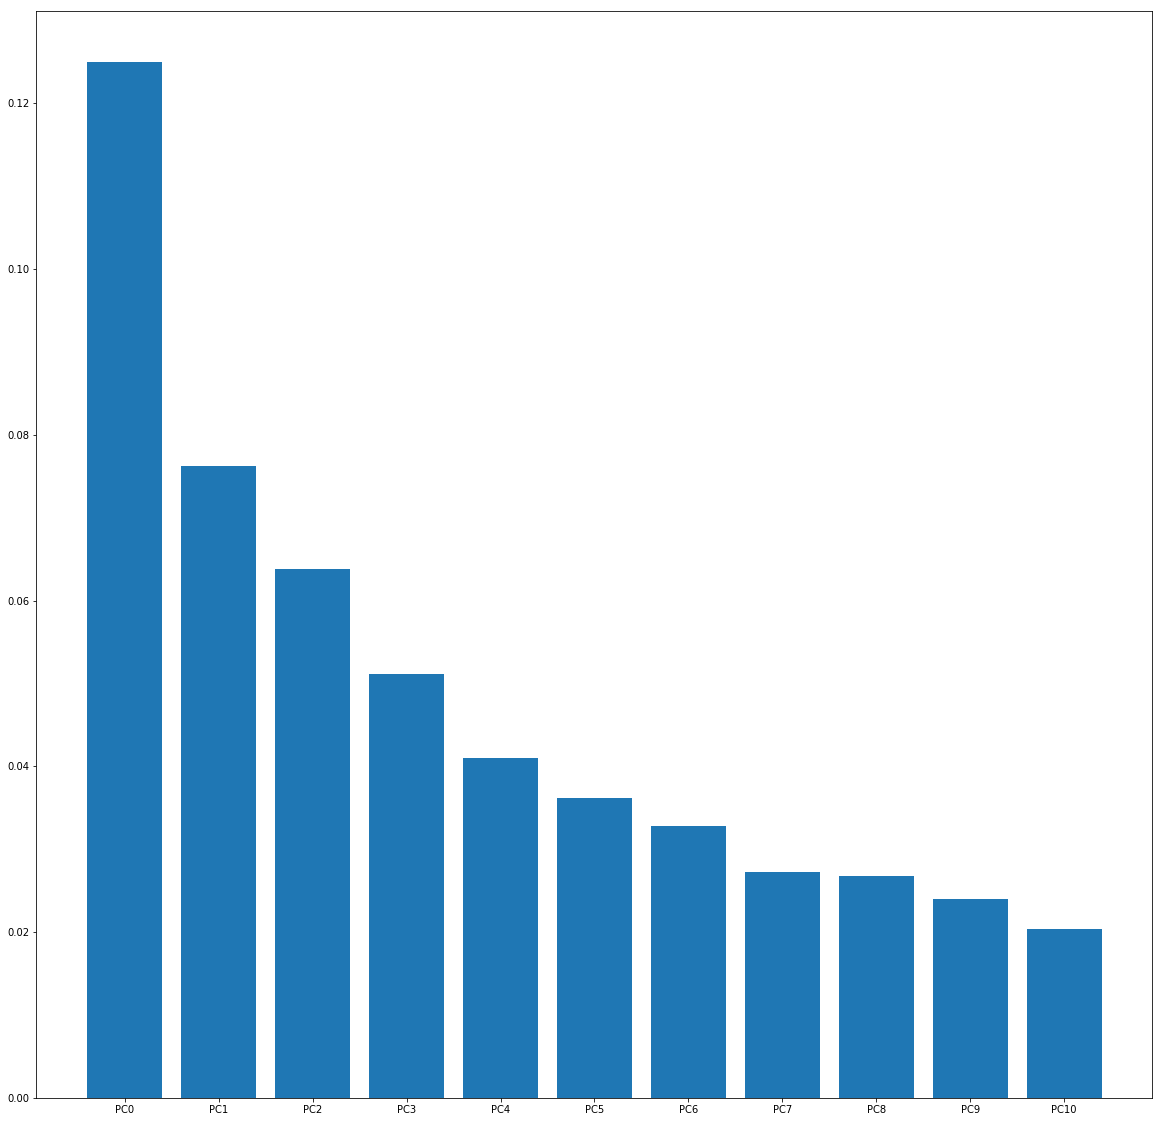

In [14]:
#PCA
pca = decomposition.PCA(n_components = 11)
#pca.fit(inner_corr[corr.loc[m,m].columns])
pca.fit(pd.concat((inner_corr,pd.get_dummies(train[categories])),axis = 1)[columns_upd])
train_data_reduced = pca.transform(pd.concat((inner_corr,pd.get_dummies(train[categories])),axis = 1)[columns_upd])
#test_columns = pd.concat((inner_corr,pd.get_dummies(train[categories])),axis = 1)[columns_upd].columns
train_data_reduced = pd.DataFrame(train_data_reduced, columns = ['PC'+str(i) for i in range (train_data_reduced.shape[1])])
train_data_PCA = pd.concat((train[['y']],train_data_reduced),axis = 1)
train_data_PCA = train_data_PCA[train_data_PCA['y'] < 220]
plt.bar(['PC'+str(i) for i in range (train_data_reduced.shape[1])],pca.explained_variance_ratio_)
test_reduced = pd.DataFrame(pca.transform(test), columns = ['PC'+str(i) for i in range (pca.transform(test).shape[1])])


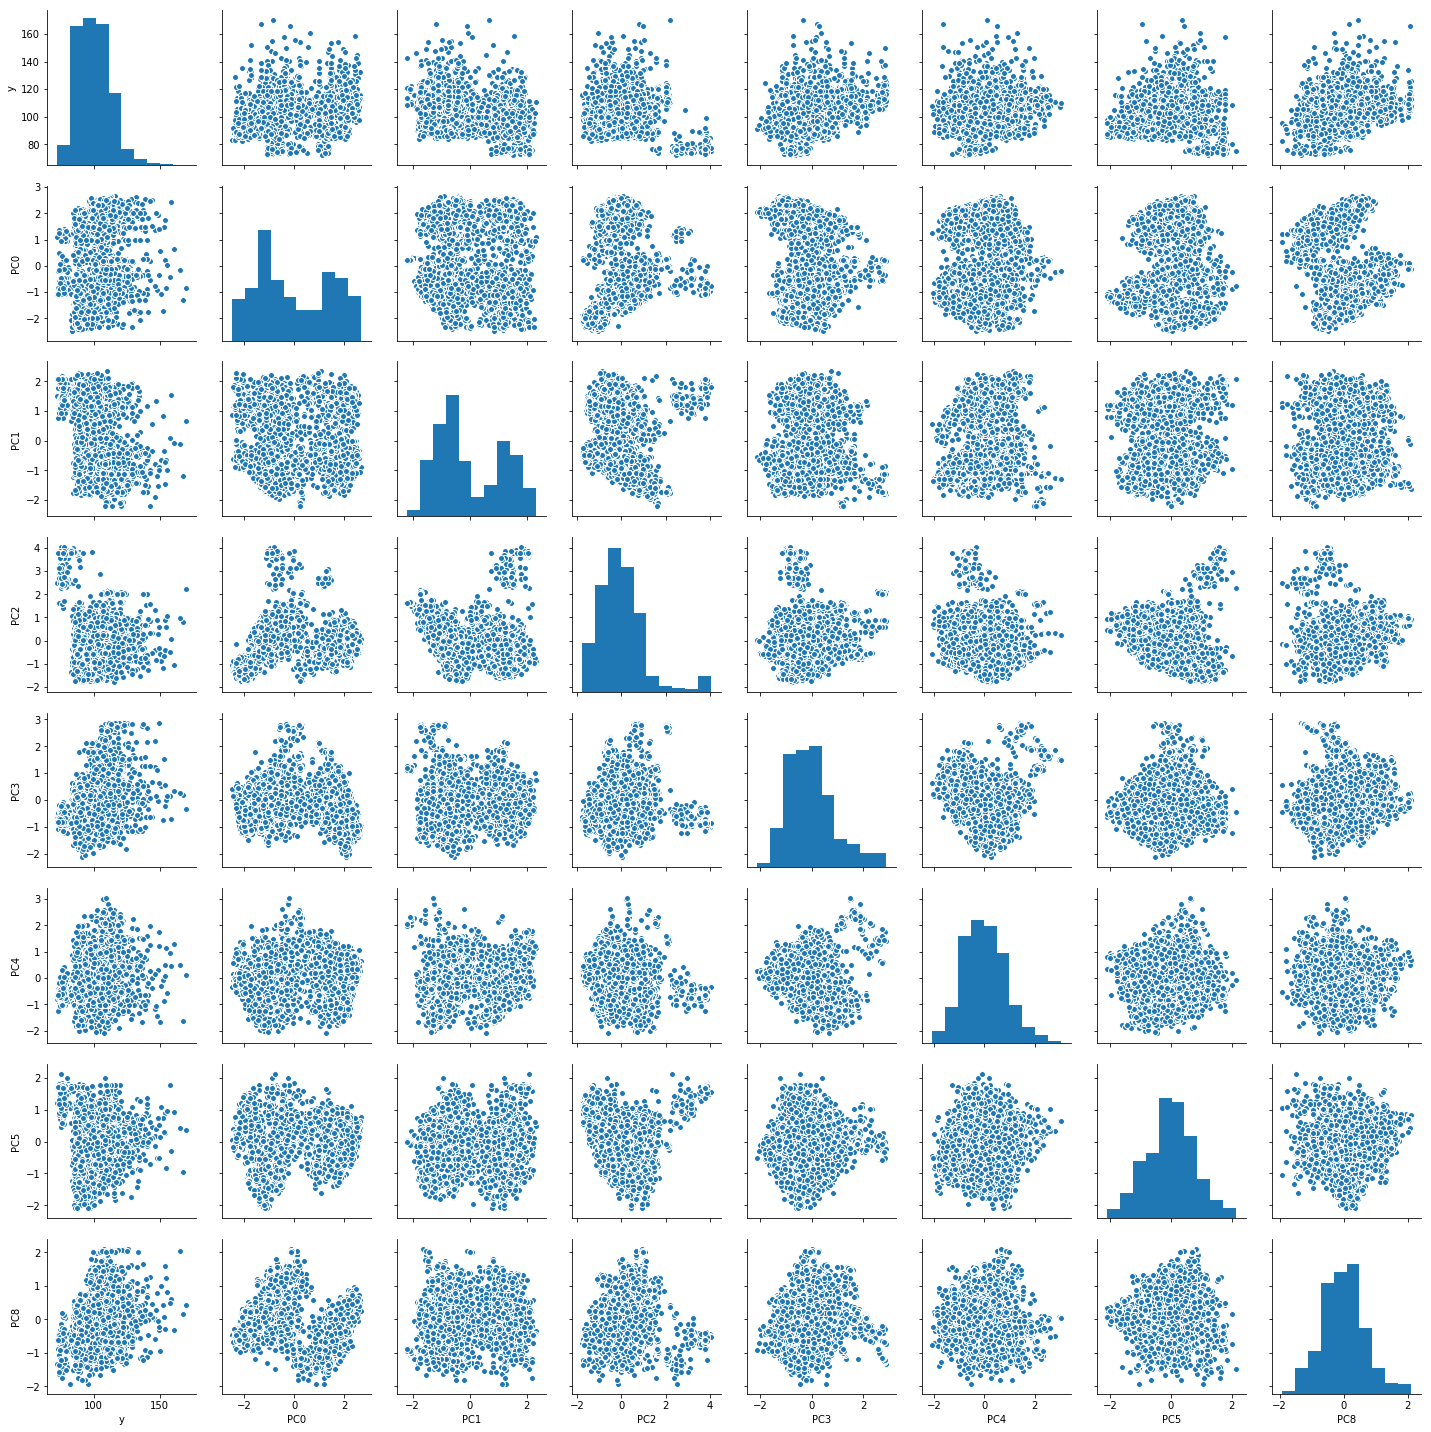

In [15]:
#Check vif
pd.Series([variance_inflation_factor(train_data_PCA.values, i) 
               for i in range(train_data_PCA.shape[1])], 
              index=train_data_PCA.columns)
#sns.pairplot(train_data_PCA)
y_corr = train_data_PCA.corr().loc[:,'y']
column_names = y_corr[(abs(y_corr) > 0.05)].index
sns.pairplot(train_data_PCA[column_names])

Converged: True


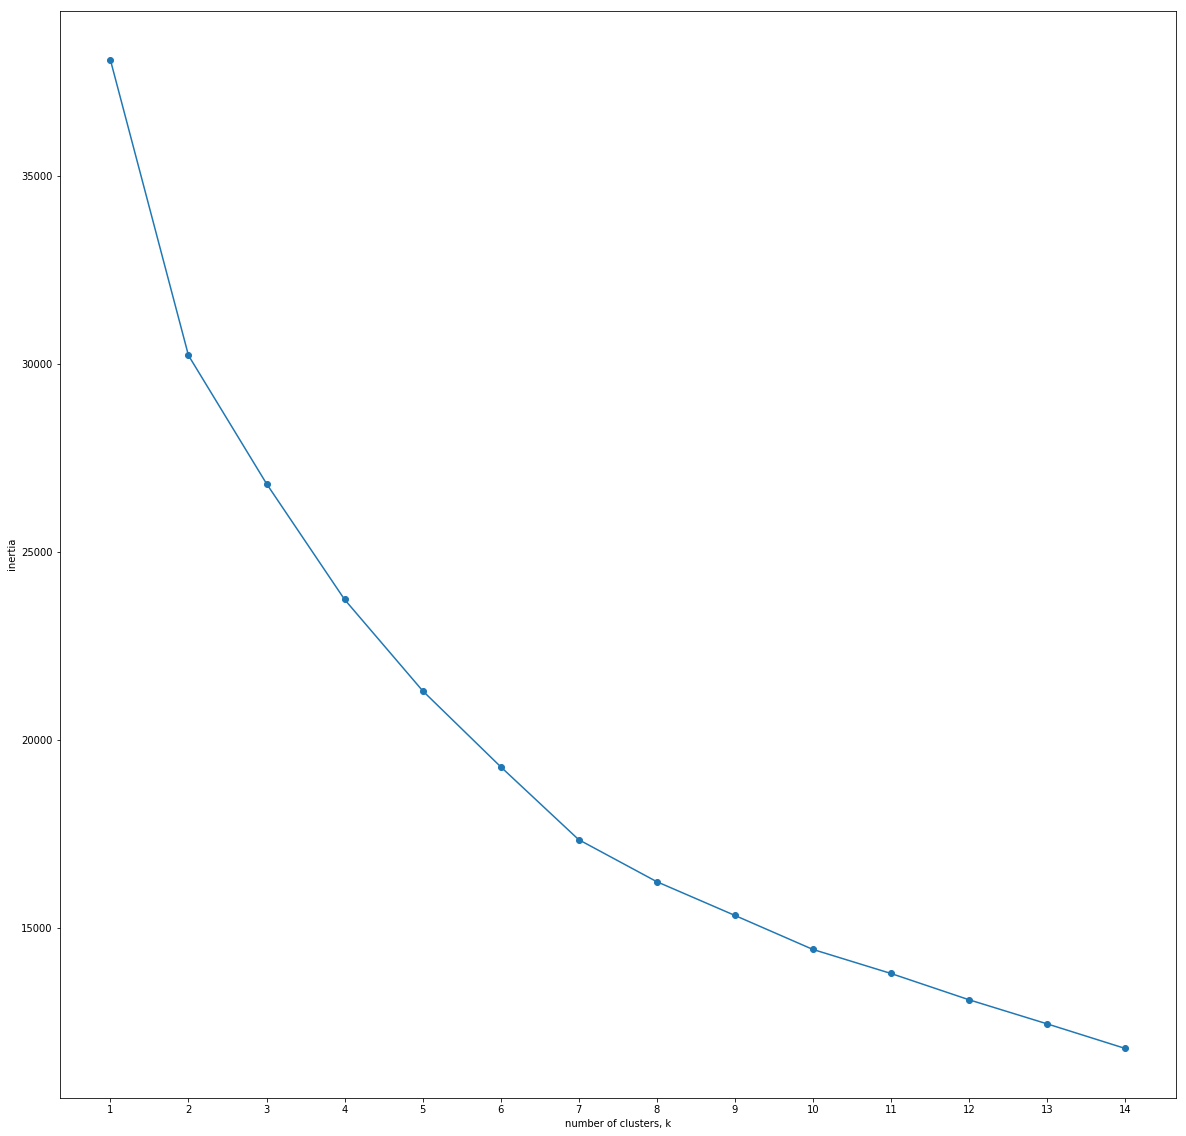

In [16]:
#Clustering with GMM
GMM_PCA = GaussianMixture(n_components=4,random_state = 31).fit(train_data_reduced) # Instantiate and fit the model
print('Converged:',GMM_PCA.converged_) # Check if the model has converged
means = GMM_PCA.means_ 
covariances = GMM_PCA.covariances_
# Predict
prediction_PCA_probs = GMM_PCA.predict_proba(train_data_PCA.loc[:,'PC0':])
pred_PCA = pd.DataFrame(prediction_PCA_probs)
GMM_cluster = []
for i in range(len(pred_PCA)):
    GMM_cluster.append(pred_PCA.iloc[i].idxmax())
pred_PCA['GMM_cluster'] = pd.DataFrame(GMM_cluster)
pred_PCA = pd.concat((train_data_PCA,pred_PCA['GMM_cluster']),axis = 1)
#Clustering with Kmeans
ncomponents = range(1,15)
inertias = []
for k in ncomponents:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(train_data_reduced)
    inertias.append(kmeans.inertia_)
plt.plot(ncomponents, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ncomponents)
plt.show()
'''I will use 4 clusters'''
kmeans = KMeans(n_clusters = 4, random_state = 31)
pred_PCA['kmeans_cluster'] = kmeans.fit(train_data_reduced).predict(train_data_reduced)
test_reduced['kmeans_cluster'] = kmeans.predict(test_reduced)

In [17]:
test_reduced.kmeans_cluster.value_counts()

0    1633
2    1242
1    1167
3     167
Name: kmeans_cluster, dtype: int64

(array([ 128.,   74., 1276.,  898., 1001.,  617.,  137.,   54.,   17.,
           6.]),
 array([4.27819273, 4.36390035, 4.44960796, 4.53531558, 4.62102319,
        4.70673081, 4.79243842, 4.87814604, 4.96385365, 5.04956127,
        5.13526889]),
 <a list of 10 Patch objects>)

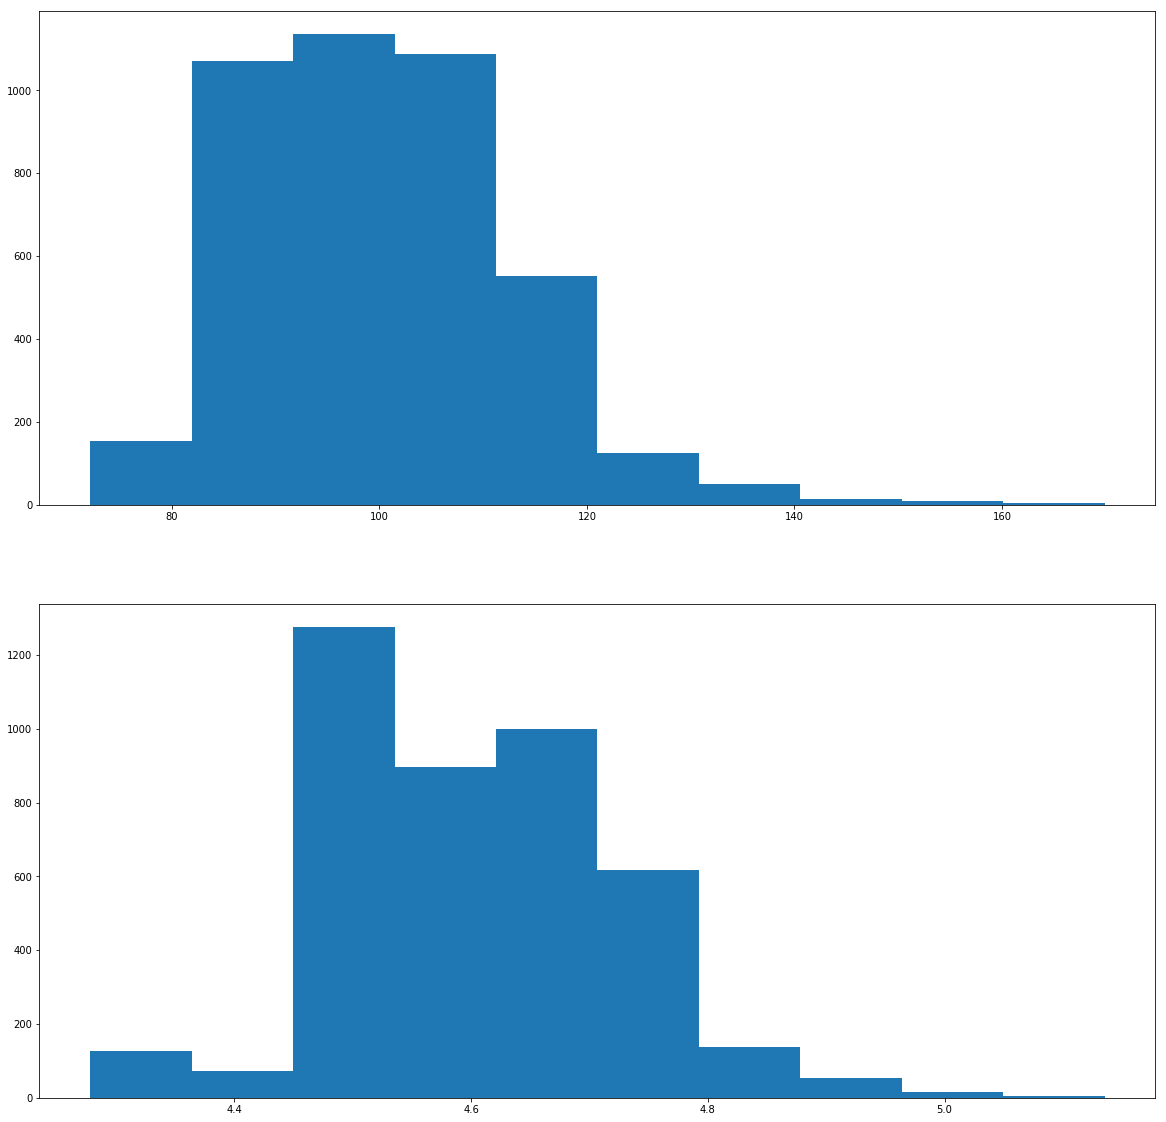

In [18]:
plt.subplot(2,1,1)
plt.hist((train_data_PCA['y']))
plt.subplot(2,1,2)
plt.hist(np.log(train_data_PCA['y']))

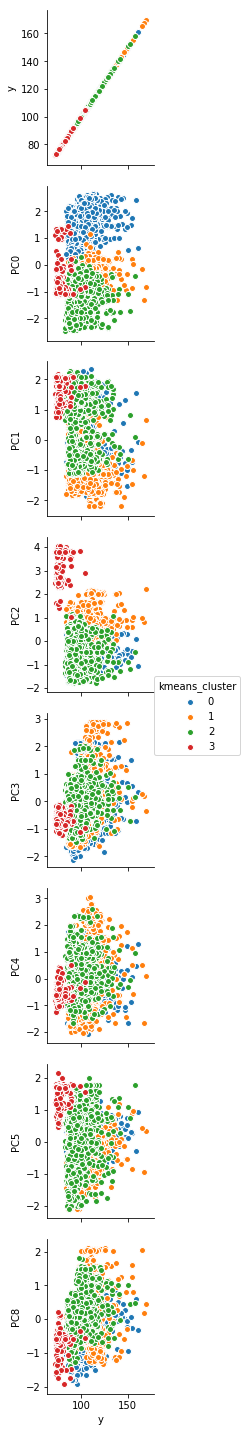

In [19]:
k = sns.pairplot(pred_PCA, x_vars = ['y'], y_vars = column_names , hue="kmeans_cluster")

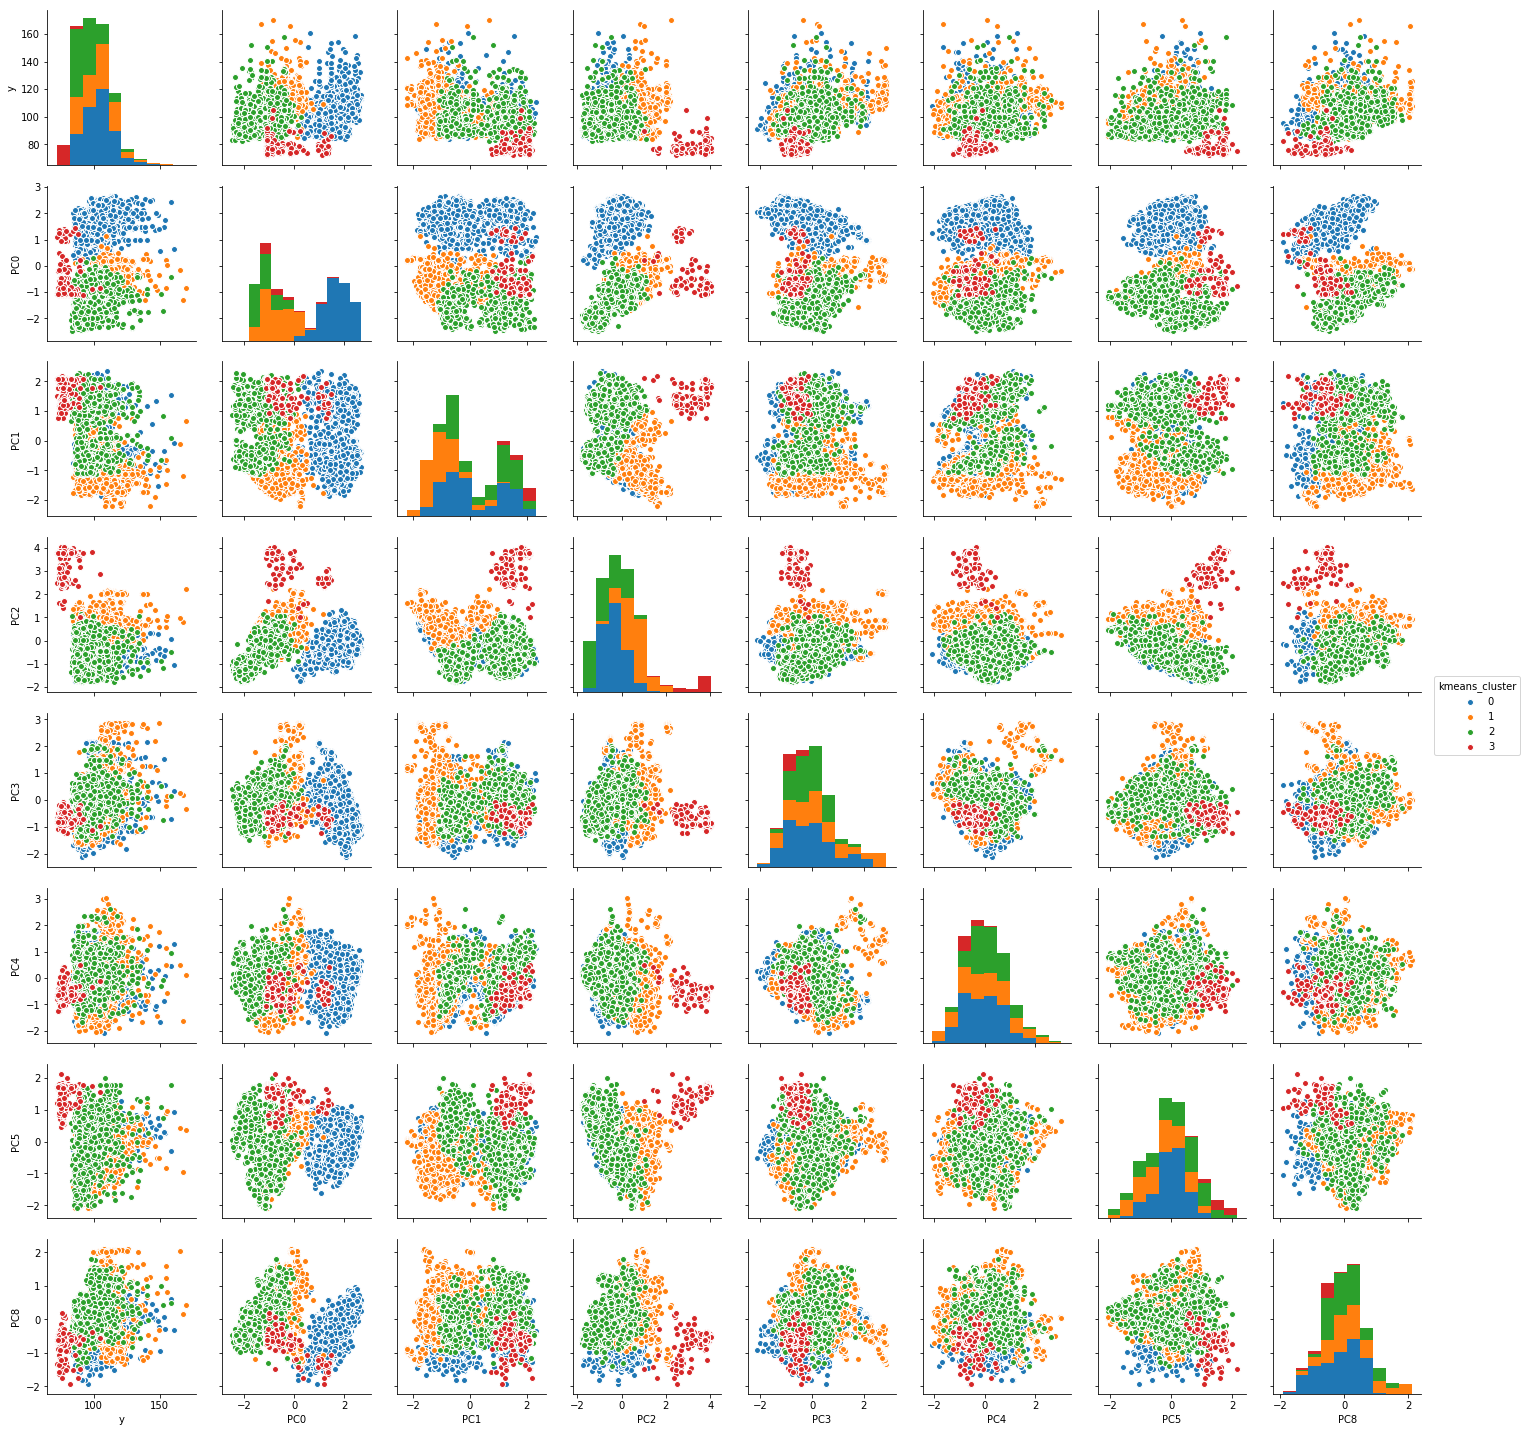

In [20]:
k = sns.pairplot(pred_PCA, x_vars = column_names, y_vars = column_names , hue="kmeans_cluster")

In [34]:
pred_PCA['kmeans_cluster'] = pred_PCA['kmeans_cluster'].astype('category')
pred_PCA['GMM_cluster'] = pred_PCA['GMM_cluster'].astype('category')
pred_PCA = pred_PCA.dropna()
test_reduced['kmeans_cluster'] = test_reduced['kmeans_cluster'].astype('category')
X_train,X_test,y_train,y_test = train_test_split(pred_PCA.loc[:,'PC0':].values , pred_PCA['y'].values, test_size = 0.20 , stratify = pred_PCA['kmeans_cluster'],random_state = 42)
X_train = pd.DataFrame(X_train,columns = pred_PCA.columns[1:],dtype = 'float').drop(columns = 'GMM_cluster')
X_test = pd.DataFrame(X_test,columns = pred_PCA.columns[1:],dtype = 'float').drop(columns = 'GMM_cluster')
X_train['kmeans_cluster'] = X_train['kmeans_cluster'].astype('category')
X_test['kmeans_cluster'] = X_test['kmeans_cluster'].astype('category')
X_train = pd.get_dummies(X_train,drop_first = True)
X_test = pd.get_dummies(X_test,drop_first = True)
df_data_test = pd.get_dummies(test_reduced, drop_first = True).dropna()
df_data_test['kmeans_cluster_1.0'] = df_data_test['kmeans_cluster_1']
df_data_test['kmeans_cluster_2.0'] = df_data_test['kmeans_cluster_2']
df_data_test['kmeans_cluster_3.0'] = df_data_test['kmeans_cluster_3']
df_data_test = df_data_test.drop(columns = ['kmeans_cluster_1','kmeans_cluster_2','kmeans_cluster_3'])

In [35]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'alpha': c_space}
parameters = {'l1_ratio':np.linspace(150,0,50)}
gbm_param_grid = {
    'n_estimators': range(1,80),
    'max_depth': np.arange(10,100,1),
    'colsample_bytree': np.arange(0.1,0.8,0.1),
    'eta': np.arange(0.1,0.8,0.01)
    
}
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet(random_state = 42)
gbm = xgb.XGBRegressor(num_boost_round = 50,
    early_stopping_rounds = 35)
est_list = [ridge, lasso, gbm]

# Instantiate the regressor: gbm
est_names = ['ridge', 'lasso','XGBoost']
for est, est_name in zip(est_list,est_names):
    if ((est == ridge) | (est == lasso)):
        model_cv = GridSearchCV(estimator = est ,  cv= 5 , param_grid= param_grid)
        model_cv.fit(X_train,y_train.reshape(-1,1))
    elif(est == gbm):
        train_dmatrix = xgb.DMatrix(data=X_train, label=y_train.reshape(-1,1))
        model_cv = RandomizedSearchCV(estimator = gbm, n_iter = 10, param_distributions = gbm_param_grid, 
                                    cv = 30, verbose = 1, random_state = 42)
        model_cv.fit(X_train,y_train)
    print(est_name, ": \n" , "best parameter:" , model_cv.best_params_ , ", R2:" , model_cv.best_score_)
#test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)
preds_2 = model_cv.predict(X_test)
r2_score(preds_2,y_test)

ridge : 
 best parameter: {'alpha': 0.05179474679231213} , R2: 0.5269569877549821
lasso : 
 best parameter: {'alpha': 0.0007196856730011522} , R2: 0.5269549203375143
Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished


XGBoost : 
 best parameter: {'n_estimators': 54, 'max_depth': 34, 'eta': 0.43999999999999984, 'colsample_bytree': 0.5} , R2: 0.46976241553223996


0.2667789996848897

[0]	eval-rmse:89.8786
Will train until eval-rmse hasn't improved in 40 rounds.
[1]	eval-rmse:80.8779
[2]	eval-rmse:72.8128
[3]	eval-rmse:65.55
[4]	eval-rmse:59.0384
[5]	eval-rmse:53.1859
[6]	eval-rmse:47.9384
[7]	eval-rmse:43.2256
[8]	eval-rmse:38.9943
[9]	eval-rmse:35.1909
[10]	eval-rmse:31.7935
[11]	eval-rmse:28.7445
[12]	eval-rmse:26.033
[13]	eval-rmse:23.6167
[14]	eval-rmse:21.449
[15]	eval-rmse:19.5639
[16]	eval-rmse:17.867
[17]	eval-rmse:16.3918
[18]	eval-rmse:15.1054
[19]	eval-rmse:13.9677
[20]	eval-rmse:12.9815
[21]	eval-rmse:12.1116
[22]	eval-rmse:11.3696
[23]	eval-rmse:10.7145
[24]	eval-rmse:10.1719
[25]	eval-rmse:9.70567
[26]	eval-rmse:9.32952
[27]	eval-rmse:9.01566
[28]	eval-rmse:8.75956
[29]	eval-rmse:8.55419
[30]	eval-rmse:8.36601
[31]	eval-rmse:8.21452
[32]	eval-rmse:8.09485
[33]	eval-rmse:7.98656
[34]	eval-rmse:7.91408
[35]	eval-rmse:7.85232
[36]	eval-rmse:7.80006
[37]	eval-rmse:7.77045
[38]	eval-rmse:7.752
[39]	eval-rmse:7.73179
[40]	eval-rmse:7.72161
[41]	eval-rmse:7.

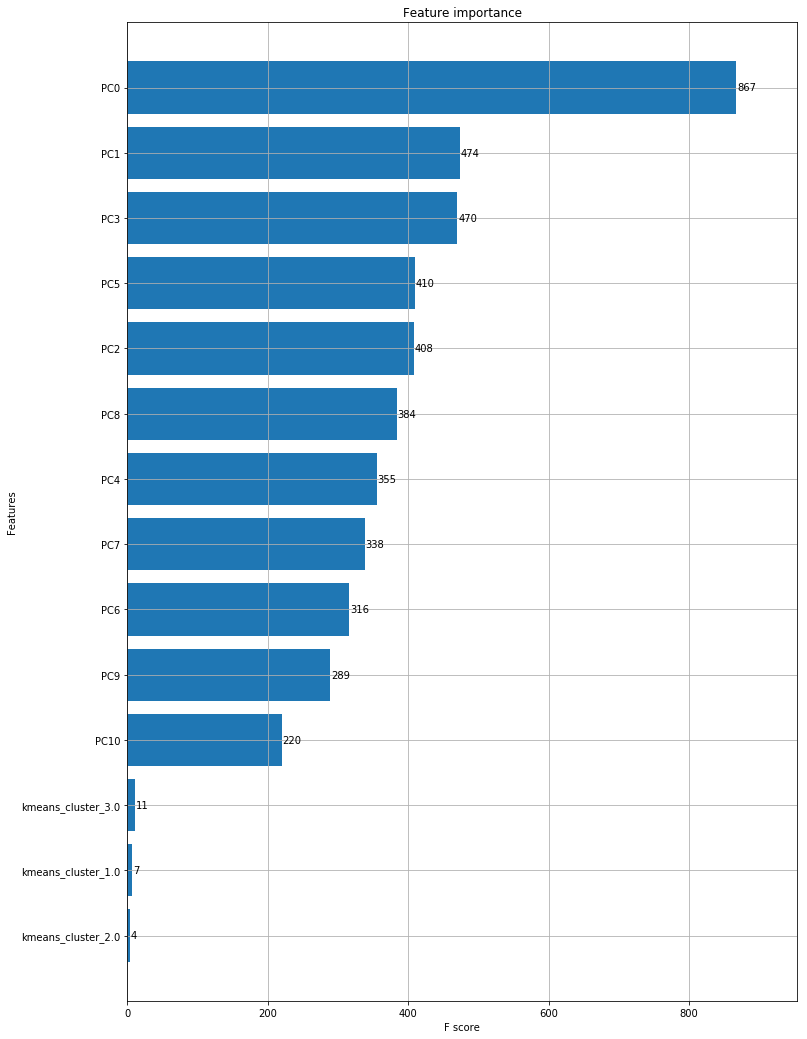

In [75]:
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)
watchlist = [(test_dmatrix, 'eval')]
xg_merso = xgb.train(params= {'n_estimators': 1, 'max_depth': 8, 'eta': 0.1, 'colsample_bytree': 0.8},
         dtrain=train_dmatrix, evals=watchlist , num_boost_round = 100 , early_stopping_rounds = 40)
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xg_merso, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [77]:
preds = xg_merso.predict(test_dmatrix)
r2_score(preds,y_test)
#plt.scatter(preds,y_test)
#xgb.plot_tree(xg_merso,num_trees = 33,rankdir = 'LR')

0.30441043803030066

In [78]:
preds_test = xg_merso.predict(xgb.DMatrix(data = df_data_test))
#preds_test = model_cv.predict(df_data_test)

In [79]:
preds_test_data = pd.concat((label_test,pd.DataFrame(preds_test)),axis = 1)

In [80]:
preds_test_data.columns = ['ID','y']

In [81]:
ridge = Ridge(alpha = 0.05179474679231213)
ridge.fit(X= X_train , y = y_train.reshape(-1,1))
pred_ridge = ridge.predict(X_test)
np.corrcoef(y_test,(preds.reshape(-1,1)*0.42 + pred_ridge*0.58).reshape(842,))[0][1]

0.7516396572150059

In [82]:
pred_ridge = ridge.predict(df_data_test)
preds_test_ridge = pd.concat((label_test,pd.DataFrame(pred_ridge)),axis = 1)
preds_test_ridge.columns = ['ID','y']
x = (preds_test.reshape(-1,1)*0.42 + pred_ridge*0.58).reshape(4209,)
pred_test_assemble = pd.DataFrame({'ID': preds_test_ridge['ID'],'y':x})

In [83]:
preds_test_data.to_csv('merso_kaggle_sub3.csv',sep=',', encoding='utf-8',index=False)

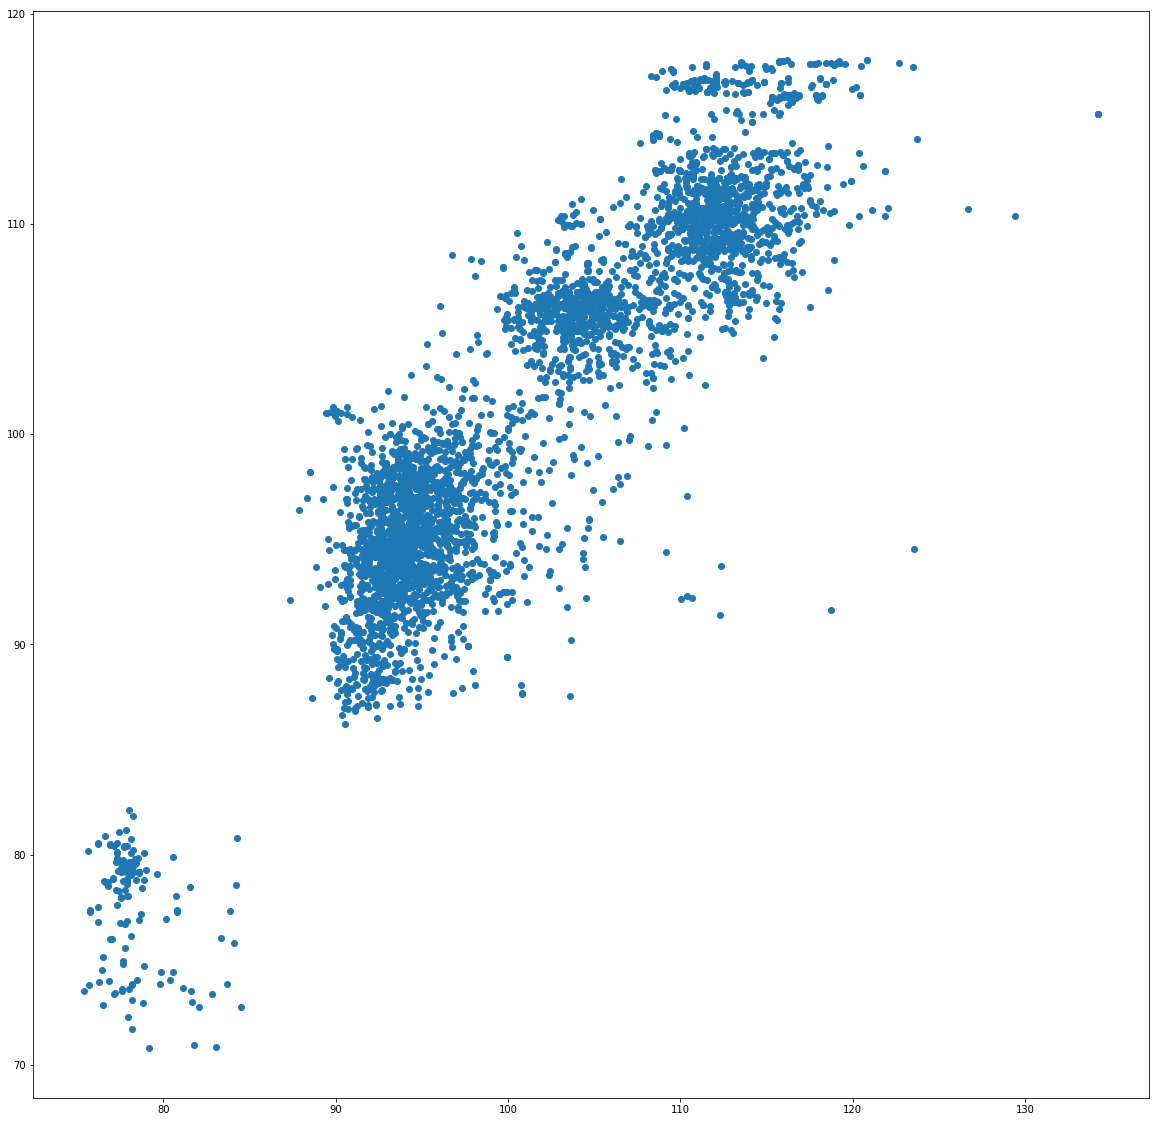

In [84]:
plt.scatter(preds_test_data['y'],preds_test_ridge['y'])

In [85]:
pred_test_assemble.to_csv('merso_kaggle_sub_asmbl.csv',sep=',', encoding='utf-8',index=False)